In [29]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.metrics import  mean_absolute_percentage_error

from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

dataset = pd.read_csv(
    "train.csv", index_col=["Date"], parse_dates=["Date"]
)

plotly_df(dataset[dataset["Store"] == 1], title="Online users")

In [30]:
dataset = dataset[dataset["Store"] == 1]

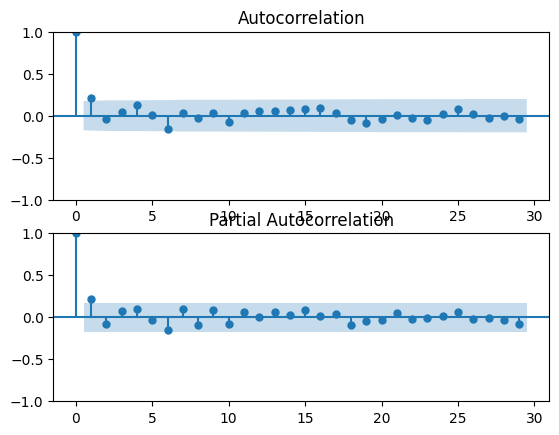

In [32]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(
    dataset["Weekly_Sales"][13:].values.squeeze(), lags=29, ax=ax
)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    dataset["Weekly_Sales"][13:].values.squeeze(), lags=29, ax=ax
)
plt.show()

In [12]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(data, lag_start=5, lag_end=20):

    data = pd.DataFrame(data.copy())

    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['Weekly_Sales'].shift(i)

    data["IsNovemberOrDecember"] = data.index.month.isin([11, 12]) * 1 
    data["NotNovemberOrDecember"] = ~data["IsNovemberOrDecember"] * 1

    data = data.dropna()
    data = data.reset_index(drop=True)

    X_train = data.drop(["Weekly_Sales"], axis=1)
    y_train = data["Weekly_Sales"]

    return X_train, y_train

In [13]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

models = []
cho = 0

for store_id in dataset['Store'].unique():
    store_data = dataset[dataset['Store'] == store_id]
    X = store_data.drop(['Store'], axis=1)
    
    X_train, y_train = prepareData(
        X, lag_start=4, lag_end=20
    )

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    models.append((store_id, model))

model_dict = {store_id: model for store_id, model in models}


In [14]:
def predict(data_path):
    test = pd.read_csv(data_path, index_col=["Date"], parse_dates=['Date'])

    all_predictions = []
    
    for store_id in test['Store'].unique():
        
        store_data = dataset[dataset['Store'] == store_id]
        X_train = store_data.drop(['Store'], axis=1)
        
        test_data = test[test['Store'] == store_id]
        X_test = test_data.drop(['Store'], axis=1)

        X = pd.concat([X_train, X_test])

        for i in range(4, 4*5):
            X["lag_{}".format(i)] = X['Weekly_Sales'].shift(i)
    
        X["IsNovemberOrDecember"] = X.index.month.isin([11, 12]) * 1 
        X["NotNovemberOrDecember"] = ~X["IsNovemberOrDecember"] * 1

        X.drop(["Weekly_Sales"], axis=1, inplace=True)

        X = X.dropna()
        X = X.reset_index(drop=True)

        X = X.tail(4)

        prediction = model_dict.get(store_id).predict(X)

        data = { "Predicted_Weekly_Sales": prediction }
        prediction_df = pd.DataFrame(data)
        all_predictions.append(prediction_df)

    final_predictions = pd.concat(all_predictions).reset_index(drop = True)
    print(final_predictions.head())
    final_predictions.to_csv('submission.csv', index_label="ID")

In [15]:
predict("test.csv")

   Predicted_Weekly_Sales
0            1.576998e+06
1            1.641729e+06
2            1.735798e+06
3            1.863745e+06
4            1.888449e+06
